.csv files link: https://drive.google.com/drive/folders/1_61paubLpjXutt7jyuvjyjRapAdz8mH9?usp=sharing

Submission link: https://forms.gle/UU4MuksSZqgNYeXK7

Form closes at: 8:00PM, June 2nd 2023. You may continue to edit the assignment until 11:59PM, June 4th 2023.


# 1. Introduction


**Import all Necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Data preparation
## 2.1 Load data

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [ ]:
print(f"Training data size is {train.shape}\nTesting data size is {test.shape}")

Training data size is (42000, 785)
Testing data size is (28000, 784)


**Set data features and labels**

In [ ]:
X = train.drop(['label'], 1).values
y = train['label'].values

<ipython-input-65-a59f6058bd32>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = train.drop(['label'], 1).values


## 2.2 Normalization

The activation values of X range from 0 to 255.
Normalize them to have a range of 0 to 1



In [ ]:
X = X/255.0

## 2.3 Reshape

In [ ]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
# canal = 1 => For gray scale
# desired X.shape = (42000, 28, 28, 1)
X = X.reshape(-1,28,28,1)
X.shape

(42000, 28, 28, 1)

## 2.4 Label encoding

**One-Hot Encoding**

In [ ]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y = to_categorical(y) # You should use Keras to do this
# previous y.shape = (42000, 1)
print(f"Label size {y.shape}")

Label size (42000, 10)


Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

## 2.5 Split training and valdiation set

In [ ]:
# Split the train and the validation set for the fitting
# Decide the val_size and read more about random_state https://stackoverflow.com/questions/28064634/random-state-pseudo-random-number-in-scikit-learn
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape # Can you explain these numbers based on the val_size that you set?

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

**Data Visualization**

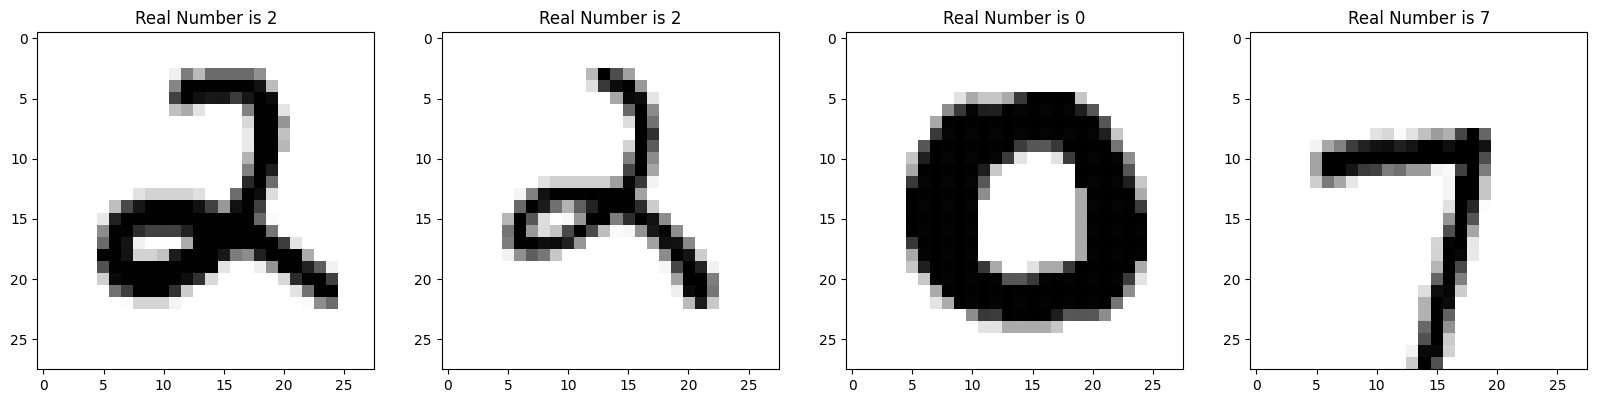

In [ ]:
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}");

**Normalization**

In [ ]:
mean = np.mean(X_train)
std = np.std(X_train)

def standardize(x):
    return (x-mean)/std # Normalize x using mean and std

# 3. CNN
## 3.1 Define the model

**Model Definition**

In [ ]:
# Change the layers of the model
# Add padding and strides wherever required

model=Sequential()

model.add(Conv2D(filters=64, kernel_size = (3,3),padding="same", activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size = (3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512,activation="relu"))

model.add(Dense(10,activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_11 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 13, 13, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_12 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 128)      

## 3.3 Model training

In [ ]:
model.fit(X, y, batch_size=128, validation_split=0.2, epochs=1) # Change the batch_size and epochs
# Number of images in X = 42000
# Validation split = 20%, so the number of images undergoing training = 80% * 42000 = 33600 = 263 * 128

263/263 [==============================] - 310s 1s/step - loss: 0.0361 - accuracy: 0.9893 - val_loss: 0.0623 - val_accuracy: 0.9802


## 4.2 Confusion matrix

132/132 [==============================] - 10s 75ms/step


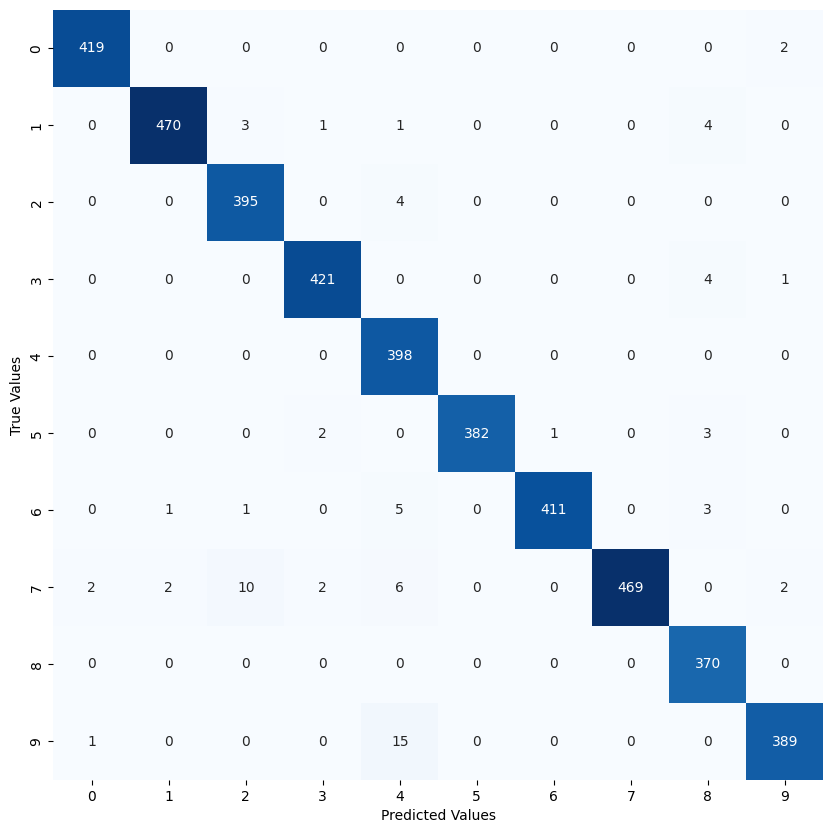

In [ ]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(X_val) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred =  np.argmax(y_pred,1) # Decode Predicted labels
Y_test = np.argmax(y_val, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

# 5. Prediction and submission




## 5.1 Prediction validation results

132/132 [==============================] - 9s 66ms/step


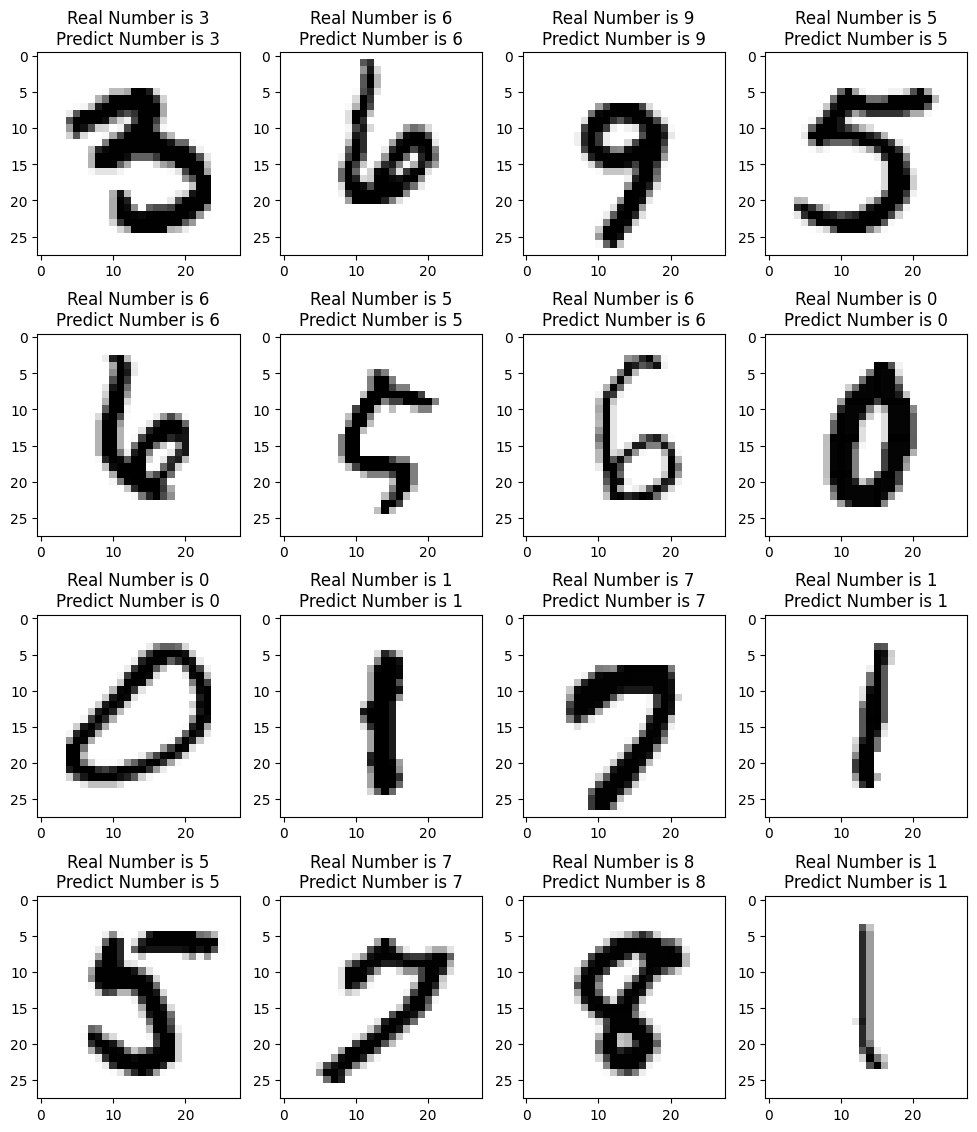

In [ ]:
y_pred = model.predict(X_val)
X_val__ = X_val.reshape(X_val.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_val__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_val[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

## 5.2 Submission

In [ ]:
# preprocess test data
test_x = test.values
test_x = test_x/255.0  # Normalize the activation values from [0,255] to [0,1]
test_x = test_x.reshape(-1,28,28,1) # Reshape the test data from 3 RGB channels to a single grayscale channel

# predict test data
pred = model.predict(test_x, verbose=1)

875/875 [==============================] - 63s 71ms/step


In [ ]:
# submissions
sub['Label'] = pred
sub.to_csv("CNN_keras_sub.csv", index=False)
sub.head()